#### Импорт библиотек

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import f1_score
from datasets import Dataset
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer
from transformers import AutoTokenizer, AutoModel, pipeline
import numpy as np
import time
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#### Определение гиперпараметров для обучения моделей

In [2]:
FRACTIONS = [0.01, 0.10, 0.20]
N_REPEATS = 10

SEED_FRACTION = 0.1
MIN_SEED = 100
BASE_RANDOM_STATE = 42

#### Загрузка датасета и предобработка данных

Используем датасет Sentiment140 для бинарной классификации негативной и позитивной эмоциональной окраски текста. Поскольку в изначальном наборе данных 1,600,000 записей и необходимо провести большое количество экспериментальных запусков нейросетевых моделей, то было принято решение сократить исходный набор данных до 1% изначального объема и работать уже с ним. В итоге всё равно получается значительный объем данных в виде 16,000 записей, корретный для формирования условий приемлемого дефицита данных.

In [ ]:
sentiment_df = pd.read_csv('Sentiment140.csv')

In [ ]:
sentiment_df = sentiment_df[['target', 'text']]
sentiment_df = sentiment_df.sample(frac=0.1, random_state=42)
sentiment_df = sentiment_df.dropna(subset=["text"])

In [ ]:
sentiment_df['target'] = sentiment_df['target'].apply(lambda x: 1 if x == 4 else 0)

#### Загрузка трансформера

В целях избежания траты времени на повторное извлечение эмбеддингов, исходный набор текстов был преобразован в таблицу CLS-эмбеддингов при помощи трансформера BERT.

In [ ]:
model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)


model = AutoModel.from_pretrained(model_name, local_files_only=True, resume_download=False).to('cuda')
feature_extractor = pipeline('feature-extraction', model=model, tokenizer=tokenizer)

In [ ]:
def extract_embeddings(example):
        output = feature_extractor(example["text"][:512])
        return {"embedding": output[0][0]}

def flatten_embeddings(example):
        for i, val in enumerate(example["embedding"]):
            example[f"{i}"] = val
        del example["embedding"]
        return example

dataset = Dataset.from_pandas(sentiment_df)
dataset = dataset.map(extract_embeddings)
messages_embeddings = dataset.map(flatten_embeddings)
messages_embeddings = messages_embeddings.to_pandas()
messages_embeddings.to_csv('embeddings.csv')

#### Определение MLP и формирование выборки

In [3]:
messages_embeddings = pd.read_csv('embeddings.csv')
messages_embeddings = messages_embeddings.sample(frac=0.1, random_state=BASE_RANDOM_STATE)

messages_embeddings = messages_embeddings.drop(columns=['Unnamed: 0', '__index_level_0__'])
X = messages_embeddings.drop(columns=['target', 'text'])
y = messages_embeddings['target']

In [4]:
mlp = MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            solver='adam',
            alpha=1e-4,
            batch_size=32,
            learning_rate_init=1e-3,
            max_iter=200,
            random_state=BASE_RANDOM_STATE,
            verbose=False
        )

scaler = StandardScaler()

#### Формирование общего враппера для избежания дублирования кода разных методов AL

In [ ]:
def select_al_batch(
    strategy_fn,
    X_train,
    y_train=None,
    model=None,
    fraction=0.1,
    seed_fraction=SEED_FRACTION,
    min_seed=MIN_SEED,
    random_state=BASE_RANDOM_STATE,
    **strategy_kwargs
):
    rng = np.random.RandomState(random_state)

    n_total = len(X_train)
    all_idx = np.arange(n_total)
    budget = max(1, int(n_total * fraction))

    seed_size = max(min_seed, int(budget * seed_fraction))
    seed_size = min(seed_size, budget)

    seed_idx = rng.choice(all_idx, size=seed_size, replace=False)
    remaining = budget - seed_size

    if remaining <= 0:
        return seed_idx

    pool_idx = np.setdiff1d(all_idx, seed_idx)

    selected_pool_idx = strategy_fn(
        X_pool=X_train[pool_idx],
        y_pool=y_train[pool_idx] if y_train is not None else None,
        model=model,
        budget=remaining,
        random_state=random_state,
        **strategy_kwargs
    )

    return np.concatenate([seed_idx, pool_idx[selected_pool_idx]])


#### Стратегия случайного выбора

In [6]:
def random_strategy(X_pool, budget, random_state=BASE_RANDOM_STATE, **_):
    rng = np.random.RandomState(random_state)
    return rng.choice(len(X_pool), size=budget, replace=False)

#### Стратегия LC

In [7]:
def lc_strategy(X_pool, model, budget, **_):
    proba = model.predict_proba(X_pool)
    max_proba = np.max(proba, axis=1)
    return np.argsort(max_proba)[:budget]

#### Стратегия MNLP

In [8]:
def mnlp_strategy(X_pool, model, budget, eps=1e-12, **_):
    proba = np.clip(model.predict_proba(X_pool), eps, 1.0)
    max_log_proba = np.max(np.log(proba), axis=1)
    score = -max_log_proba
    return np.argsort(-score)[:budget]

#### Стратегия Coreset

In [9]:
def coreset_strategy(X_pool, budget, random_state=BASE_RANDOM_STATE, **_):
    rng = np.random.RandomState(random_state)

    selected = [rng.randint(len(X_pool))]
    dist = pairwise_distances(X_pool, X_pool[selected]).min(axis=1)

    for _ in range(budget - 1):
        i = np.argmax(dist)
        selected.append(i)
        dist = np.minimum(
            dist,
            pairwise_distances(X_pool, X_pool[[i]]).reshape(-1)
        )

    return np.array(selected)

#### Стратегия Cluster Margin

In [10]:
def cluster_margin_strategy(X_pool, model, budget, random_state=42, **_):
    proba = model.predict_proba(X_pool)
    part = np.partition(-proba, kth=1, axis=1)
    margin = -part[:, 0] + part[:, 1]

    kmeans = KMeans(
        n_clusters=budget,
        random_state=random_state,
        n_init="auto"
    )
    labels = kmeans.fit_predict(X_pool)

    selected = []
    for c in range(budget):
        idx = np.where(labels == c)[0]
        selected.append(idx[np.argmin(margin[idx])])

    return np.array(selected)

#### Стратегия Embeddings KM

In [11]:
def embeddings_km_strategy(X_pool, budget, random_state=BASE_RANDOM_STATE, **_):
    kmeans = KMeans(
        n_clusters=budget,
        random_state=random_state,
        n_init="auto"
    )
    labels = kmeans.fit_predict(X_pool)
    centers = kmeans.cluster_centers_

    selected = []
    for k in range(budget):
        cluster_idx = np.where(labels == k)[0]
        dists = pairwise_distances(
            X_pool[cluster_idx],
            centers[k].reshape(1, -1)
        )
        selected.append(cluster_idx[np.argmin(dists)])

    return np.array(selected)

#### Словарь названий стратегий для вывода

In [12]:
AL_METHODS = {
    "Random": random_strategy,
    "LC": lc_strategy,
    "MNLP": mnlp_strategy,
    "Coreset": coreset_strategy,
    "EmbeddingsKM": embeddings_km_strategy,
    "ClusterMargin": cluster_margin_strategy
}

#### Функция запуска обучения с заданной стратегией, данными, и объемом выборки

In [13]:
def run_experiment(method_name, strategy_fn, X, y, fraction, run_id):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.1,
        stratify=y,
        random_state=BASE_RANDOM_STATE + run_id
    )

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.values
    y_test = y_test.values

    idx = select_al_batch(
        strategy_fn=strategy_fn,
        X_train=X_train_scaled,
        y_train=y_train,
        model=mlp,
        fraction=fraction,
        seed_fraction=SEED_FRACTION,
        min_seed=MIN_SEED,
        random_state=BASE_RANDOM_STATE
    )

    mlp.fit(X_train_scaled[idx], y_train[idx])
    y_pred = mlp.predict(X_test_scaled)

    return f1_score(y_test, y_pred)

#### Общий цикл обучения

In [ ]:
results = []

for method_name, strategy_fn in AL_METHODS.items():
    print(f'Метод: {method_name}')
    for frac in FRACTIONS:
        print(f'Обучающая выборка: {frac}')
        scores = []

        for run in range(N_REPEATS):
            f1 = run_experiment(
                method_name,
                strategy_fn,
                X,
                y,
                frac,
                run
            )
            scores.append(f1)
            print(f'f1={round(f1, 3)}')

        results.append({
            "method": method_name,
            "fraction": frac,
            "mean_f1": np.mean(scores),
        })
        print(f'средний f1={round(np.mean(scores), 3)}\n')


Метод: Random
Обучающая выборка: 0.01
0.01
f1=0.709
f1=0.655
f1=0.712
f1=0.624
f1=0.709
f1=0.698
f1=0.725
f1=0.735
f1=0.686
f1=0.704
средний f1=0.696
Обучающая выборка: 0.1
0.1
f1=0.746
f1=0.751
f1=0.762
f1=0.75
f1=0.746
f1=0.758
f1=0.752
f1=0.765
f1=0.744
f1=0.748
средний f1=0.752
Обучающая выборка: 0.2
0.2
f1=0.763
f1=0.752
f1=0.772
f1=0.759
f1=0.748
f1=0.772
f1=0.743
f1=0.772
f1=0.75
f1=0.766
средний f1=0.76
Метод: LC
Обучающая выборка: 0.01
0.01
f1=0.657
f1=0.655
f1=0.714
f1=0.651
f1=0.685
f1=0.674
f1=0.74
f1=0.709
f1=0.701
f1=0.708
средний f1=0.689
Обучающая выборка: 0.1
0.1
f1=0.741
f1=0.728
f1=0.751
f1=0.722
f1=0.732
f1=0.728
f1=0.732
f1=0.751
f1=0.736
f1=0.756
средний f1=0.737
Обучающая выборка: 0.2
0.2
f1=0.752
f1=0.755
f1=0.748
f1=0.726
f1=0.714
f1=0.768
f1=0.74
f1=0.749
f1=0.72
f1=0.732
средний f1=0.74
Метод: MNLP
Обучающая выборка: 0.01
0.01
f1=0.684
f1=0.677
f1=0.69
f1=0.664
f1=0.703
f1=0.694
f1=0.725
f1=0.718
f1=0.687
f1=0.703
средний f1=0.694
Обучающая выборка: 0.1
0.1
f

#### Формирование датафрейма результатов обучения

In [60]:
results_df = pd.DataFrame(results)
results_df.sort_values(
    by=["fraction", "mean_f1"],
    ascending=[True, False]
)

,method,fraction,mean_f1
12,EmbeddingsKM,0.01,0.703993
9,Coreset,0.01,0.703570
0,Random,0.01,0.695797
6,MNLP,0.01,0.694406
15,ClusterMargin,0.01,0.693315
3,LC,0.01,0.689473
13,EmbeddingsKM,0.10,0.756163
10,Coreset,0.10,0.754337
1,Random,0.10,0.752145
16,ClusterMargin,0.10,0.750435


#### Baseline

In [34]:
def run_full_data_baseline(X, y, run_id):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.1,
        stratify=y,
        random_state=BASE_RANDOM_STATE + run_id
    )

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    mlp.fit(X_train_scaled, y_train.values)
    y_pred = mlp.predict(X_test_scaled)

    return f1_score(y_test.values, y_pred)

scores = [run_full_data_baseline(X, y, run) for run in range(N_REPEATS)]
baseline_f1 = np.mean(scores)

#### Формирование графика сравнения методов

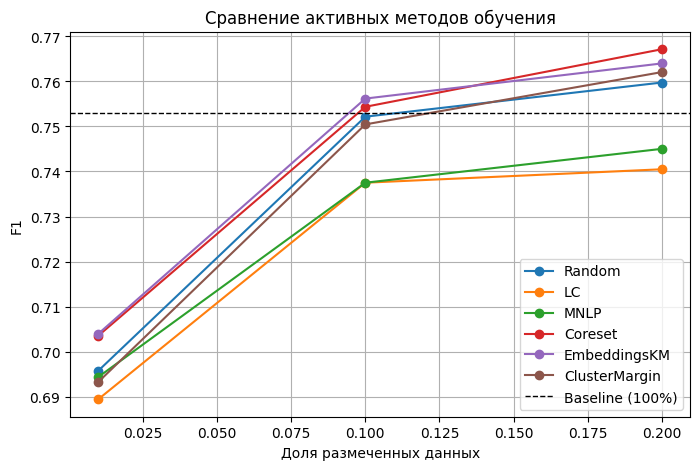

In [37]:
plot_df = results_df[results_df["fraction"].isin([0.01, 0.10, 0.20])]

plt.figure(figsize=(8, 5))

for method in plot_df["method"].unique():
    sub = plot_df[plot_df["method"] == method]
    sub = sub.sort_values("fraction")
    plt.plot(
        sub["fraction"],
        sub["mean_f1"],
        marker="o",
        label=method
    )

plt.axhline(
    y=baseline_f1,
    linestyle="--",
    linewidth=1,
    label="Baseline (100%)",
    color='black'
)

plt.xlabel("Доля размеченных данных")
plt.ylabel("F1")
plt.title("Сравнение активных методов обучения")
plt.legend()
plt.grid(True)

plt.show()

#### Первоначальный код запуска без единой архитектуры

In [23]:
def select_lc_indices(
    model,
    X_train,
    y_train,
    fraction: float,
    seed_fraction: float = 0.1,
    min_seed: int = 100,
    random_state: int = 42
) -> np.ndarray:
    rng = np.random.RandomState(random_state)
    n_total = len(X_train)
    all_idx = np.arange(n_total)

    budget_size = max(1, int(n_total * fraction))

    seed_size = max(min_seed, int(budget_size * seed_fraction))
    seed_size = min(seed_size, budget_size)

    seed_idx = rng.choice(all_idx, size=seed_size, replace=False)
    pool_idx = np.setdiff1d(all_idx, seed_idx)

    model.fit(X_train[seed_idx], y_train[seed_idx])

    remaining = budget_size - seed_size
    if remaining <= 0:
        return seed_idx

    proba = model.predict_proba(X_train[pool_idx])
    max_proba = np.max(proba, axis=1)

    order = np.argsort(max_proba)
    add_idx = pool_idx[order[:remaining]]

    return np.concatenate([seed_idx, add_idx])

In [24]:
def select_mnlp_indices(
    model,
    X_train,
    y_train,
    fraction: float,
    seed_fraction: float = 0.1,
    min_seed: int = 100,
    random_state: int = 42
) -> np.ndarray:
    eps = 1e-12
    rng = np.random.RandomState(random_state)
    n_total = len(X_train)
    all_idx = np.arange(n_total)

    budget_size = max(1, int(n_total * fraction))

    seed_size = max(min_seed, int(budget_size * seed_fraction))
    seed_size = min(seed_size, budget_size)

    seed_idx = rng.choice(all_idx, size=seed_size, replace=False)
    pool_idx = np.setdiff1d(all_idx, seed_idx)

    model.fit(X_train[seed_idx], y_train[seed_idx])

    remaining = budget_size - seed_size
    if remaining <= 0:
        return seed_idx

    proba = model.predict_proba(X_train[pool_idx])
    proba = np.clip(proba, eps, 1.0)
    max_log_proba = np.max(np.log(proba), axis=1)
    n_classes = proba.shape[1]
    mnlp_score = -max_log_proba / np.log(n_classes)

    order = np.argsort(-mnlp_score)
    add_idx = pool_idx[order[:remaining]]

    return np.concatenate([seed_idx, add_idx])

In [25]:
def select_coreset_indices(
    X_train,
    fraction,
    seed_fraction,
    min_seed,
    random_state,
    metric = "euclidean"
):
    rng = np.random.RandomState(random_state)

    n_total = len(X_train)
    all_idx = np.arange(n_total)

    budget_size = max(1, int(n_total * fraction))

    seed_size = max(min_seed, int(budget_size * seed_fraction))
    seed_size = min(seed_size, budget_size)

    seed_idx = rng.choice(all_idx, size=seed_size, replace=False)

    if seed_size == budget_size:
        return seed_idx

    selected = list(seed_idx)
    remaining = budget_size - seed_size

    dist_to_selected = pairwise_distances(
        X_train, X_train[selected], metric=metric
    ).min(axis=1)

    dist_to_selected[selected] = 0.0

    for _ in range(remaining):
        next_idx = np.argmax(dist_to_selected)
        selected.append(next_idx)

        new_dist = pairwise_distances(
            X_train, X_train[[next_idx]], metric=metric
        ).reshape(-1)

        dist_to_selected = np.minimum(dist_to_selected, new_dist)
        dist_to_selected[selected] = 0.0

    return np.array(selected)


In [26]:
def select_embeddings_km_indices(
    X_train,
    fraction,
    seed_fraction,
    min_seed,
    random_state,
    metric = "euclidean"
):
    rng = np.random.RandomState(random_state)

    n_total = len(X_train)
    all_idx = np.arange(n_total)

    budget_size = max(1, int(n_total * fraction))

    seed_size = max(min_seed, int(budget_size * seed_fraction))
    seed_size = min(seed_size, budget_size)

    seed_idx = rng.choice(all_idx, size=seed_size, replace=False)

    remaining = budget_size - seed_size
    if remaining <= 0:
        return seed_idx

    kmeans = KMeans(
        n_clusters=remaining,
        random_state=random_state,
        n_init="auto"
    )
    kmeans.fit(X_train)

    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    selected = list(seed_idx)

    for k in range(remaining):
        cluster_idx = np.where(labels == k)[0]

        if len(cluster_idx) == 0:
            continue

        cluster_points = X_train[cluster_idx]
        center = centers[k].reshape(1, -1)

        dists = pairwise_distances(cluster_points, center, metric=metric)
        closest = cluster_idx[np.argmin(dists)]

        selected.append(closest)

    selected = np.unique(selected)

    if len(selected) < budget_size:
        missing = budget_size - len(selected)
        candidates = np.setdiff1d(all_idx, selected)
        extra = rng.choice(candidates, size=missing, replace=False)
        selected = np.concatenate([selected, extra])

    return selected[:budget_size]


In [27]:
def select_cluster_margin_indices(
    model,
    X_train,
    y_train,
    fraction,
    seed_fraction,
    min_seed,
    random_state
):
    rng = np.random.RandomState(random_state)

    n_total = len(X_train)
    all_idx = np.arange(n_total)

    budget_size = max(1, int(n_total * fraction))

    seed_size = max(min_seed, int(budget_size * seed_fraction))
    seed_size = min(seed_size, budget_size)

    seed_idx = rng.choice(all_idx, size=seed_size, replace=False)
    pool_idx = np.setdiff1d(all_idx, seed_idx)

    model.fit(X_train[seed_idx], y_train[seed_idx])

    remaining = budget_size - seed_size
    if remaining <= 0:
        return seed_idx

    proba = model.predict_proba(X_train[pool_idx])
    part = np.partition(-proba, kth=1, axis=1)
    p1 = -part[:, 0]
    p2 = -part[:, 1]
    margin = p1 - p2

    n_clusters = min(remaining, len(pool_idx))

    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=random_state,
        n_init="auto"
    )
    cluster_labels = kmeans.fit_predict(X_train[pool_idx])

    selected = list(seed_idx)
    selected_pool = set()

    for c in range(n_clusters):
        cluster_indices = np.where(cluster_labels == c)[0]
        if len(cluster_indices) == 0:
            continue

        best_local = cluster_indices[np.argmin(margin[cluster_indices])]
        selected_pool.add(pool_idx[best_local])

        if len(selected_pool) >= remaining:
            break

    selected = np.concatenate([seed_idx, np.array(list(selected_pool))])

    if len(selected) < budget_size:
        missing = budget_size - len(selected)
        candidates = np.setdiff1d(all_idx, selected)
        extra = rng.choice(candidates, size=missing, replace=False)
        selected = np.concatenate([selected, extra])

    return selected[:budget_size]


In [28]:
# fractions = [0.01, 0.10, 0.20]
fractions = [0.01, 0.10]
n_repeats = 2
methods = ['random', 'lc', 'coreset', 'mnlp', 'embeddings_km', 'cluster_margin']
results2 = []

for frac in fractions:
    print(f'Обучающая выборка: {frac}')
    for method_name in methods:
        print(f'Метод: {method_name}')
        scores = []
        for run in range(n_repeats):

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.1, random_state=42 + run, stratify=y
            )
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            y_train = y_train.values
            y_test = y_test.values

            if method_name == 'lc':
                idx = select_lc_indices(model=mlp,
                        X_train=X_train_scaled, y_train=y_train,
                        fraction=frac,
                        seed_fraction=0.1,
                        min_seed=100,
                        random_state=42
                )
            
            if method_name == 'coreset':
                idx = select_coreset_indices(
                    X_train=X_train_scaled,
                    fraction=frac,
                    seed_fraction=0.1,
                    min_seed=100,
                    random_state=42
                )

            if method_name == 'mnlp':
                idx = select_mnlp_indices(
                    model=mlp,
                    X_train=X_train_scaled,
                    y_train=y_train,
                    fraction=frac,
                    seed_fraction=0.1,
                    min_seed=100,
                    random_state=42
                )

            if method_name == 'embeddings_km':
                idx = select_embeddings_km_indices(
                    X_train=X_train_scaled,
                    fraction=frac,
                    seed_fraction=0.1,
                    min_seed=100,
                    random_state=42
                )

            if method_name == 'cluster_margin':
                idx = select_cluster_margin_indices(
                    model=mlp,
                    X_train=X_train_scaled,
                    y_train=y_train,
                    fraction=frac,
                    seed_fraction=0.1,
                    min_seed=100,
                    random_state=42
                )
            if method_name == 'random':
                idx = X_train.sample(frac=frac, random_state=42 + run).index
                idx = X_train.index.isin(idx)

            mlp.fit(X_train_scaled[idx], y_train[idx])
            y_pred = mlp.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred)

            f1 = f1_score(y_test, y_pred)
            print(f"  Запуск {run+1}: F1 = {f1:.3f}")
            scores.append(f1)

        results2.append({
            "method": method_name,
            "fraction": frac,
            "mean_f1": np.mean(scores),
        })
        print(f'  средний f1={round(np.mean(scores), 3)}\n')

Обучающая выборка: 0.01
Метод: random
  Запуск 1: F1 = 0.677
  Запуск 2: F1 = 0.707
Метод: lc
  Запуск 1: F1 = 0.669
  Запуск 2: F1 = 0.697
Метод: coreset
  Запуск 1: F1 = 0.687
  Запуск 2: F1 = 0.678
Метод: mnlp
  Запуск 1: F1 = 0.669
  Запуск 2: F1 = 0.697
Метод: embeddings_km
  Запуск 1: F1 = 0.688
  Запуск 2: F1 = 0.695
Метод: cluster_margin
  Запуск 1: F1 = 0.705
  Запуск 2: F1 = 0.684
Обучающая выборка: 0.1
Метод: random


c:\Users\vsu70\Desktop\ai-labs-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


  Запуск 1: F1 = 0.736
  Запуск 2: F1 = 0.762
Метод: lc
  Запуск 1: F1 = 0.762
  Запуск 2: F1 = 0.760
Метод: coreset
  Запуск 1: F1 = 0.770
  Запуск 2: F1 = 0.760
Метод: mnlp
  Запуск 1: F1 = 0.762
  Запуск 2: F1 = 0.760
Метод: embeddings_km
  Запуск 1: F1 = 0.764
  Запуск 2: F1 = 0.772
Метод: cluster_margin
  Запуск 1: F1 = 0.753
  Запуск 2: F1 = 0.765


In [29]:
results_df = pd.DataFrame(results)
results_df.sort_values(
    by=["fraction", "mean_f1"],
    ascending=[True, False]
)

,method,fraction,mean_f1
12,EmbeddingsKM,0.01,0.703993
9,Coreset,0.01,0.703570
0,Random,0.01,0.695797
6,MNLP,0.01,0.694406
15,ClusterMargin,0.01,0.693315
3,LC,0.01,0.689473
13,EmbeddingsKM,0.10,0.756163
10,Coreset,0.10,0.754337
1,Random,0.10,0.752145
16,ClusterMargin,0.10,0.750435
